In [ ]:
# Operator Learning via Kernel Methods
#
# This is mostly a script for prototyping methods

In [1]:
# Imports
import numpy as np
import sklearn as skl
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import sys
sys.path.append('./')
from KLearn import *
from functools import reduce
from scipy import integrate
import matplotlib.pyplot as plt

In [2]:
# Define Operators

# Identity Operator (Linear)
def op_I(u):
    return u

# Scaling Operator (Linear)
def op_a(u):
    a = 10;
    return a*u

# Squaring Operator (Slightly Nonlinear)
def op_square(u):
    return u**2

# Sine Operator (Contractive)
def op_sin(u):
    return np.sin(u)

# Discrete Integration (Linear, Discrete)
def op_int(u,x,N_mesh,N):
    ints = np.zeros((np.shape(u)))
    idx = []
    for i in range(0, N_mesh):
        idx.append(i)
        ints[i][:] = integrate.simpson(u[idx][:], x[idx], axis = 0)
    return ints

# Discrete Double Integration
def op_int2(u,x,N_mesh,N):
    return op_int(op_int(u,x,N_mesh,N),x,N_mesh,N)

In [3]:
### Generating Data

## GP kernel

def gp_kernel(t,σ):
  return np.exp( - (1/(2*σ**2))*t**2)

N_mesh = 100
a = 0
b = 1
x = np.linspace(a,b, N_mesh) # fine grid for visualization
X = x.reshape((-1,1))
dx = (b-a)/N_mesh

## compute pairwise distance matrix

dist_matrix = pairwise_distances(X,X)

## GP lengthscale
σ = 0.1
Cov_matrix = gp_kernel(dist_matrix, σ) + 1e-8*np.eye(N_mesh)
Cov_matrix = 1/2*(Cov_matrix + Cov_matrix.T)

Cov_matrix_sqrt = np.linalg.cholesky(Cov_matrix)

In [4]:
def opL_fxn(u_train,v_train,u_test,v_test,X):
    # Finish setting up
    U = u_train;
    V = v_train;
    Y = X;

    # Define some Kernels again (this time, parameterized)
    K_ = lambda g: (lambda y1,y2 : rbf_kernel(y1,y2, gamma = g))
    S_ = lambda s : (lambda x1,x2 : rbf_kernel(x1,x2, gamma = s)) # lame, for now
    kgrid = np.linspace(10,100, 100)
    sgrid = 1/np.power(5,range(1,12))

    # LEARN AGAIN!
    D,f = OpLearn(U,V, S_,sgrid, K_,kgrid,Y)
    v_mod = D(u_test);
    return v_mod

In [70]:
# Define Error Values
def err_vals(v_mod,v_test,Y):
    # L1 Error (Averaged over Each Test Function)
    L1_err = dx*sum(np.abs(v_mod(Y) - v_test))
    L1_err_abs = np.average(L1_err)
    L1_err_rel = np.average(np.divide(L1_err, dx*sum(np.abs(v_test))))

    # L2 Error (Averaged over Each Test Function)
    L2_err = np.sqrt(dx*sum(np.square(np.abs(v_mod(Y) - v_test))))
    L2_err_abs = np.average(L2_err)
    L2_err_rel = np.average(np.divide(L2_err, np.sqrt(dx*sum(np.square(np.abs(v_test))))))

    # L_inf Error (Averaged over Each Test Function)
    Linf_err = np.max(np.abs(v_mod(Y) - v_test),axis=0)
    Linf_err_abs = np.average(Linf_err)
    Linf_err_rel = np.average(np.divide(Linf_err, np.max(np.abs(v_test),axis=0)))
    return np.array([L1_err_abs, L1_err_rel, L2_err_abs, L2_err_rel, Linf_err_abs, Linf_err_rel])

In [71]:
def all_ops_err(u_train,u_test,X,N_mesh,N_train,N_test):
    v_train_I = op_I(u_train)
    v_test_I = op_I(u_test)
    v_mod_I = opL_fxn(u_train,v_train_I,u_test,v_test_I,X)
    err_vals_I = err_vals(v_mod_I,v_test_I,X)

    v_train_a = op_a(u_train)
    v_test_a = op_a(u_test)
    v_mod_a = opL_fxn(u_train,v_train_a,u_test,v_test_a,X)
    err_vals_a = err_vals(v_mod_a,v_test_a,X)

    v_train_sq = op_square(u_train)
    v_test_sq = op_square(u_test)
    v_mod_sq = opL_fxn(u_train,v_train_sq,u_test,v_test_sq,X)
    err_vals_sq = err_vals(v_mod_sq,v_test_sq,X)

    v_train_sin = op_sin(u_train)
    v_test_sin = op_sin(u_test)
    v_mod_sin = opL_fxn(u_train,v_train_sin,u_test,v_test_sin,X)
    err_vals_sin = err_vals(v_mod_sin,v_test_sin,X)

    v_train_int = op_int(u_train,X,N_mesh,N_train)
    v_test_int = op_int(u_test,X,N_mesh,N_test)
    v_mod_int = opL_fxn(u_train,v_train_int,u_test,v_test_int,X)
    err_vals_int = err_vals(v_mod_int,v_test_int,X)
    
    opL_errs = np.row_stack((err_vals_I,err_vals_a,err_vals_sq,err_vals_sin,err_vals_int))
    return opL_errs

In [72]:
def Data_vals(N):
    N_train = N       # Number of training functions
    N_test  = 100     # Number of testing functions
    u_train = np.zeros((N_mesh, N_train))
    u_test  = np.zeros((N_mesh, N_test))

    for i in range(N_train):
      xi = np.random.randn(N_mesh)
      u_train[:, i] = np.dot(Cov_matrix_sqrt, xi)

    for i in range(N_test):
      xi = np.random.randn(N_mesh)
      u_test [:, i] = np.dot(Cov_matrix_sqrt, xi)
        
    return u_train, u_test, N_train, N_test

In [73]:
## Training and test functions
N = [10, 20, 40, 100, 150, 200] #, 400, 600, 800, 1000, 1250, 1500, 2000, 2400]
Errs_op_mesh = np.zeros((5,6,len(N)))

for i in range(0,len(N)):
    u_train, u_test, N_train, N_test = Data_vals(N[i])
    ERRS = all_ops_err(u_train,u_test,X,N_mesh,N_train,N_test)
    Errs_op_mesh[:,:,i] = ERRS[:,:]

Optimal gamma = 2.56e-06
Optimal gamma = 44.54545454545455
Optimal gamma = 2.56e-06
Optimal gamma = 44.54545454545455
Optimal gamma = 0.008
Optimal gamma = 92.72727272727272
Optimal gamma = 0.0016
Optimal gamma = 93.63636363636364
Optimal gamma = 5.12e-07
Optimal gamma = 36.36363636363636
Optimal gamma = 5.12e-07
Optimal gamma = 50.0
Optimal gamma = 5.12e-07
Optimal gamma = 50.0
Optimal gamma = 0.008
Optimal gamma = 98.18181818181817
Optimal gamma = 0.0016
Optimal gamma = 90.0
Optimal gamma = 5.12e-07
Optimal gamma = 41.81818181818181
Optimal gamma = 5.12e-07
Optimal gamma = 48.18181818181818
Optimal gamma = 5.12e-07
Optimal gamma = 48.18181818181818
Optimal gamma = 0.00032
Optimal gamma = 100.0
Optimal gamma = 0.008
Optimal gamma = 100.0
Optimal gamma = 5.12e-07
Optimal gamma = 36.36363636363636
Optimal gamma = 2.56e-06
Optimal gamma = 49.090909090909086
Optimal gamma = 2.56e-06
Optimal gamma = 49.090909090909086
Optimal gamma = 6.4e-05
Optimal gamma = 100.0
Optimal gamma = 0.008
Opti

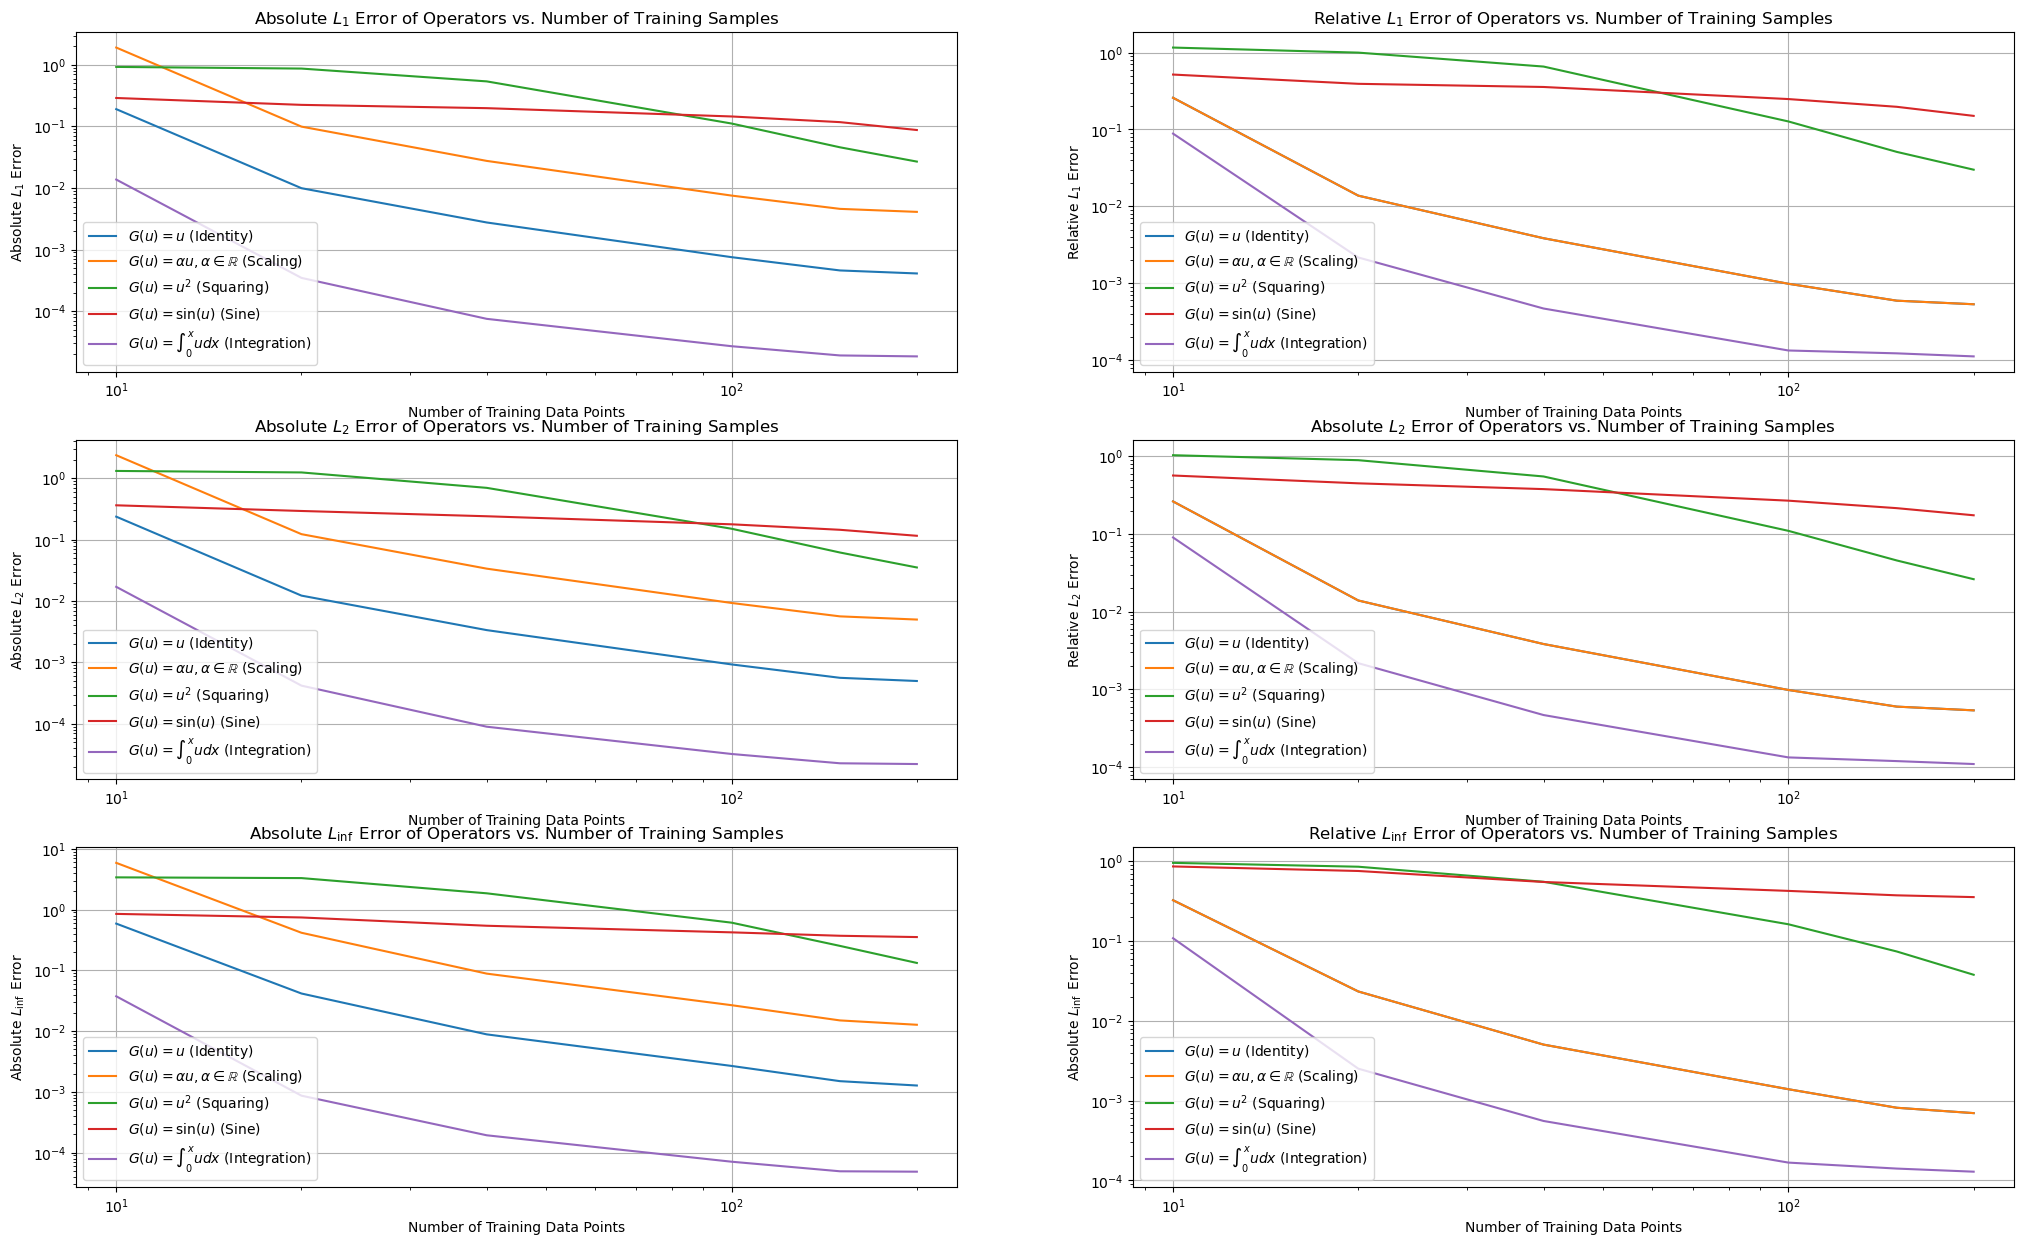

In [88]:
# L2 Error Plot
L1_Errs = Errs_op_mesh[:,0,:]
L1_Errs_Rel = Errs_op_mesh[:,1,:]
L2_Errs = Errs_op_mesh[:,2,:]
L2_Errs_Rel = Errs_op_mesh[:,3,:]
Linf_Errs = Errs_op_mesh[:,4,:]
Linf_Errs_Rel = Errs_op_mesh[:,5,:]

fig, ax = plt.subplots(3,2)
fig.set_size_inches(25,15)

ax[0,0].loglog(np.outer(np.ones((5,)),N).T,L1_Errs.T)
ax[0,0].set( xlabel ='Number of Training Data Points', ylabel='Absolute $L_1$ Error', title = "Absolute $L_1$ Error of Operators vs. Number of Training Samples")
ax[0,0].legend(['$G(u) = u$ (Identity)', r'$G(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G(u) = u^2$ (Squaring)', '$G(u) = \sin(u)$ (Sine)', '$G(u) = \int_0^x u dx$ (Integration)'])
ax[0,0].grid()

ax[0,1].loglog(np.outer(np.ones((5,)),N).T,L1_Errs_Rel.T)
ax[0,1].set( xlabel ='Number of Training Data Points', ylabel='Relative $L_1$ Error', title = "Relative $L_1$ Error of Operators vs. Number of Training Samples")
ax[0,1].legend(['$G(u) = u$ (Identity)', r'$G(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G(u) = u^2$ (Squaring)', '$G(u) = \sin(u)$ (Sine)', '$G(u) = \int_0^x u dx$ (Integration)'])
ax[0,1].grid()

ax[1,0].loglog(np.outer(np.ones((5,)),N).T,L2_Errs.T)
ax[1,0].set( xlabel ='Number of Training Data Points', ylabel='Absolute $L_2$ Error', title = "Absolute $L_2$ Error of Operators vs. Number of Training Samples")
ax[1,0].legend(['$G(u) = u$ (Identity)', r'$G(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G(u) = u^2$ (Squaring)', '$G(u) = \sin(u)$ (Sine)', '$G(u) = \int_0^x u dx$ (Integration)'])
ax[1,0].grid()

ax[1,1].loglog(np.outer(np.ones((5,)),N).T,L2_Errs_Rel.T)
ax[1,1].set( xlabel ='Number of Training Data Points', ylabel='Relative $L_2$ Error', title = "Absolute $L_2$ Error of Operators vs. Number of Training Samples")
ax[1,1].legend(['$G(u) = u$ (Identity)', r'$G(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G(u) = u^2$ (Squaring)', '$G(u) = \sin(u)$ (Sine)', '$G(u) = \int_0^x u dx$ (Integration)'])
ax[1,1].grid()

ax[2,0].loglog(np.outer(np.ones((5,)),N).T,Linf_Errs.T)
ax[2,0].set( xlabel ='Number of Training Data Points', ylabel='Absolute $L_\inf$ Error', title = "Absolute $L_\inf$ Error of Operators vs. Number of Training Samples")
ax[2,0].legend(['$G(u) = u$ (Identity)', r'$G(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G(u) = u^2$ (Squaring)', '$G(u) = \sin(u)$ (Sine)', '$G(u) = \int_0^x u dx$ (Integration)'])
ax[2,0].grid()

ax[2,1].loglog(np.outer(np.ones((5,)),N).T,Linf_Errs_Rel.T)
ax[2,1].set( xlabel ='Number of Training Data Points', ylabel='Absolute $L_\inf$ Error', title = "Relative $L_\inf$ Error of Operators vs. Number of Training Samples")
ax[2,1].legend(['$G(u) = u$ (Identity)', r'$G(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G(u) = u^2$ (Squaring)', '$G(u) = \sin(u)$ (Sine)', '$G(u) = \int_0^x u dx$ (Integration)'])
ax[2,1].grid()

fig.savefig('Error_Plots.png', dpi=300, bbox_inches='tight')